# Demand Forecast using Machine Learning with Python

Demand forecasting is a technique for estimation of probable demand for a product or service in the future. Demand means outside requirements of a product or service. In general, forecasting means making an estimation in the present for a future occurring event.

### Data Preparation
First, we prepare our data, after importing our needed modules we load the data into a pandas dataframe. In the supplied train.csv there are 50 items in this example we’ll do predictions of sales for item 1 on a weekly basis. The data is separated by days, and stores that sold that particular item in no particular order. After filtering our and grouping our first few rows should look like this:

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('./data/train.csv')
df = df[df['item'] == 1]
df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
df = df.filter(['date', 'sales']).groupby([pd.Grouper(key='date', freq='W-MON')]).sum().reset_index()

df.head(3)

,date,sales
0,2012-12-31,894
1,2013-01-07,863
2,2013-01-14,867


In [5]:
df['shift_sale'] = df['sales'].shift(1)
df = df.iloc[1:]

df.head(5)

,date,sales,shift_sale
2,2013-01-14,867,863.0
3,2013-01-21,816,867.0
4,2013-01-28,969,816.0
5,2013-02-04,920,969.0
6,2013-02-11,943,920.0


Because we don’t have the week before our first entry we just drop that row. Another column we want to make is a four-week average. For that, we’ll write a quick method.

In [6]:
def four_week_avg(sales):
    sum = 0
    week_avg = []
    for i in range(3, -1, -1):
        for j in range(i):
            sum += sales[j]
        if(i!=0):
            week_avg.append(sum/i)
        sum = 0
    week_avg.append(sales[0])
    week_avg.reverse()
    for row in range(len(sales) - 4):
        for row in range(row, row + 4):
            sum += sales[row]
        week_avg.append(sum / 4)
        sum = 0
    return week_avg

The first part is for the rows where we don’t have four sales values to use for our average. After applying this to our dataframe should look like this.


In [7]:
df['week_avg'] = four_week_avg(df['sales'].tolist())
print(df.head())

        date  sales  shift_sale  week_avg
2 2013-01-14    867       863.0     867.0
3 2013-01-21    816       867.0     867.0
4 2013-01-28    969       816.0     841.5
5 2013-02-04    920       969.0     884.0
6 2013-02-11    943       920.0     893.0


### Model creation
Let’s first import our modules for our model and metrics to be able to assess how good our model did.

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, max_error

Then we will split our data into a training set and a test set for evaluation later. Let’s try to forecast sales for 1 year, which is 52 weeks.


In [10]:
test = df.iloc[-52:]
df = df.iloc[:-52]

In [34]:
test

,date,sales,shift_sale,week_avg
209,2017-01-02,1182,1261.0,1257.75
210,2017-01-09,1216,1182.0,1244.25
211,2017-01-16,1207,1216.0,1230.00
212,2017-01-23,1141,1207.0,1216.50
213,2017-01-30,1288,1141.0,1186.50
214,2017-02-06,1360,1288.0,1213.00
215,2017-02-13,1296,1360.0,1249.00
216,2017-02-20,1326,1296.0,1271.25
217,2017-02-27,1519,1326.0,1317.50
218,2017-03-06,1508,1519.0,1375.25


Now for the easiest part, using scikits module for splitting data we will be able to split the training data for our model to learn on. After we trained our model we first check how it did with the data it trained on.


In [29]:
X = df.drop(['sales','date'], axis=1)
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [30]:
clf = svm.SVR(C=1, kernel='linear', degree=8, gamma='scale', coef0=10)


In [32]:
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(f'Model fit results:\n'
      f'r2_score {r2_score(y_test, predictions)} \t MSE {mean_squared_error(y_test, predictions)}'
      f'\tEVS {explained_variance_score(y_test, predictions)} \n MAE {mean_absolute_error(y_test, predictions)}'
      f'\tMAD {median_absolute_error(y_test, predictions)}\t ME {max_error(y_test, predictions)}')


Model fit results:
r2_score 0.8800597547492767 	 MSE 8710.494407593187	EVS 0.8800599428032642 
 MAE 67.98915498116652	MAD 52.859214138792595	 ME 368.30680065005436


The r2 and EVS as closer to 1 the better, the rest should be lowest as possible.

Now let’s test it with the data we dropped out at the beginning.

In [37]:
predictions = clf.predict(test.drop(['sales','date'], axis=1))
print(f'Model test results:\n'
      f'r2_score {r2_score(test["sales"], predictions)} \t MSE {mean_squared_error(test["sales"], predictions)}'
      f'\tEVS {explained_variance_score(test["sales"], predictions)} \n MAE {mean_absolute_error(test["sales"], predictions)}'
      f'\tMAD {median_absolute_error(test["sales"], predictions)}\t ME {max_error(test["sales"], predictions)}')
      

Model test results:
r2_score 0.9001115467176138 	 MSE 10047.680624628834	EVS 0.9004085022090752 
 MAE 72.50960884211123	MAD 52.28732897565351	 ME 319.23678647130146


In [38]:
predictions

array([1266.17775184, 1187.34589511, 1221.86199845, 1213.232063  ,
       1147.92173754, 1294.56838813, 1365.72000964, 1300.88268662,
       1329.61246905, 1521.47508425, 1509.35794956, 1554.59406792,
       1491.19047673, 1621.7983077 , 1829.01769798, 1833.94775364,
       1864.25609647, 1818.62574303, 1978.93875346, 1874.30140077,
       1941.90351408, 1979.81326788, 1982.77791878, 2082.52182797,
       2120.29957315, 2030.64681881, 2130.82342291, 2217.06231614,
       2230.27397961, 2227.79699878, 2223.08141445, 1907.42581368,
       1911.77840275, 1920.0911935 , 1949.23721245, 1844.44769739,
       1846.96683342, 1841.55089848, 1813.47931146, 1730.09506196,
       1759.83875815, 1749.50373982, 1724.10345121, 1654.47356728,
       1766.75997226, 1727.81615095, 1816.39816871, 1809.23678647,
       1482.37344371, 1305.96663853, 1306.74223184, 1264.68714029])

In [42]:
test['predictions'] = predictions

In [44]:
test.head()

,date,sales,shift_sale,week_avg,predictions
209,2017-01-02,1182,1261.0,1257.75,1266.177752
210,2017-01-09,1216,1182.0,1244.25,1187.345895
211,2017-01-16,1207,1216.0,1230.00,1221.861998
212,2017-01-23,1141,1207.0,1216.50,1213.232063
213,2017-01-30,1288,1141.0,1186.50,1147.921738


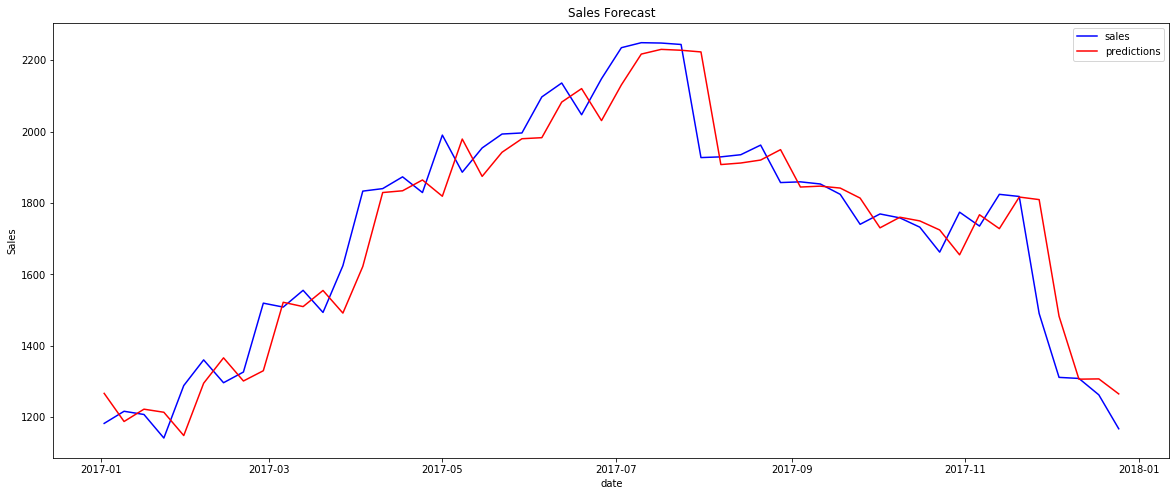

In [46]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
plt.figure(figsize=(20, 8))
plt.plot(test['date'], test['sales'], 'b-', label = 'sales')
plt.plot(test['date'], test['predictions'], 'r-', label = 'predictions')
plt.xlabel('date'); plt.ylabel('Sales'); plt.title('Sales Forecast')
register_matplotlib_converters()
plt.legend();